### Import

In [ ]:
# related third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import time
from tqdm import tqdm
import pickle
import random
import networkx as nx
import optuna
import ray
from ray import tune
from ray.tune.search.optuna import OptunaSearch
from torchviz import make_dot
import graphviz

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.utils import dropout_adj, convert

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

import shap
import warnings

# local application/library specific imports
from models.gin import GIN
from models.gcn import GCN
from models.gat import GAT

from utils import *
from processing.woe_processing import *
from processing.correlation_feature_selector import CorrelationFeatureSelector
from train_utils import train, evaluate, train_and_evaluate
from setup import *
from plot_cap_curve import *


### Data loading

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv('data/FICO/heloc.csv')
df.replace({'RiskPerformance' : { 'Bad' : 1, 'Good' : 0}}, inplace=True)

In [4]:
df.head(5)

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69
1,1,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0
2,1,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86
3,1,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91
4,1,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80


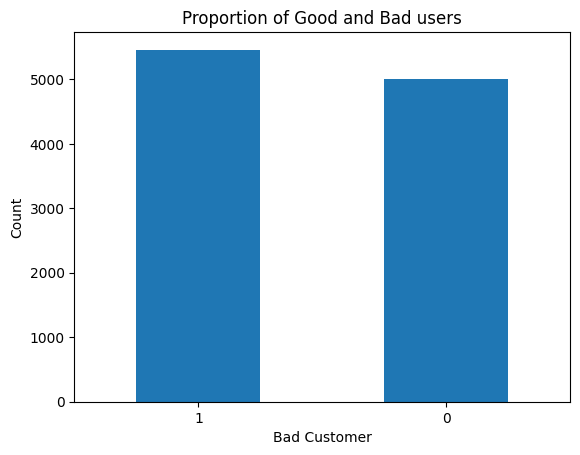

In [5]:
ax = df['RiskPerformance'].value_counts().plot(kind='bar')
ax.set_xlabel('Bad Customer')
ax.set_ylabel('Count')
ax.set_title('Proportion of Good and Bad users')
ax.set_xticklabels(ax.get_xticklabels(), rotation=360)
#plt.savefig('BadCustomer.png', transparent=True, dpi=200)
plt.show()

### Binning

In [6]:
variable_names = list(df.columns[1:])

# mirroring statsmodels logistic regression
lr_params = {
    "fit_intercept": True,
    "penalty": "none",
    "random_state": 72,
    "solver": "newton-cg",
    }

In [7]:
df_copy = df.copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df_copy[df_copy.loc[:, df_copy.columns != 'RiskPerformance'].columns],
    df_copy['RiskPerformance'],
    test_size=0.3,
    random_state=62
    )

ExternalRiskEstimate 

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 63.50)   1942   0.265264        458   1484    0.764161   
1       [63.50, 65.50)    455   0.062150        129    326    0.716484   
2       [65.50, 67.50)    438   0.059828        132    306    0.698630   
3       [67.50, 70.50)    730   0.099713        274    456    0.624658   
4       [70.50, 72.50)    468   0.063926        225    243    0.519231   
5       [72.50, 74.50)    458   0.062560        228    230    0.502183   
6       [74.50, 76.50)    440   0.060101        256    184    0.418182   
7       [76.50, 78.50)    370   0.050540        234    136    0.367568   
8       [78.50, 80.50)    409   0.055867        276    133    0.325183   
9       [80.50, 83.50)    516   0.070482        385    131    0.253876   
10      [83.50, 87.50)    657   0.089742        526    131    0.199391   
11        [87.50, inf)    438   0.059828        369     69    0.157534   
12             

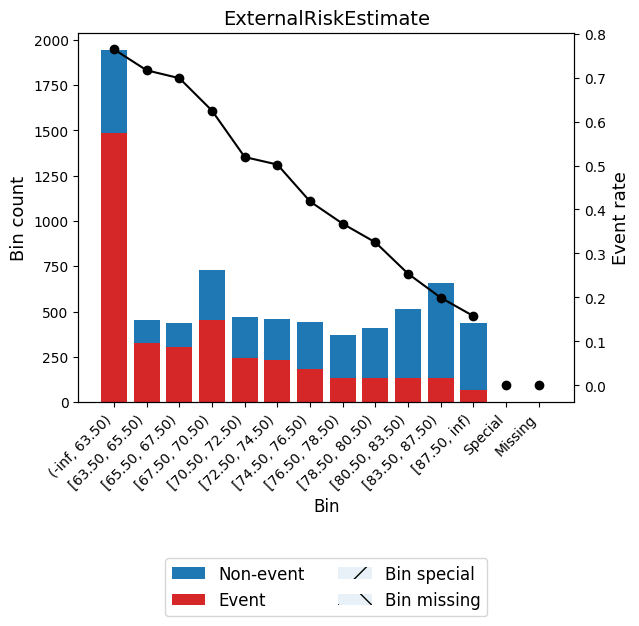

None


---

MSinceOldestTradeOpen 

                     Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 118.50)   1824   0.249146        595   1229    0.673794   
1       [118.50, 134.50)    418   0.057096        159    259    0.619617   
2       [134.50, 147.50)    375   0.051223        159    216    0.576000   
3       [147.50, 175.50)    969   0.132359        460    509    0.525284   
4       [175.50, 212.50)   1145   0.156399        593    552    0.482096   
5       [212.50, 265.50)   1028   0.140418        557    471    0.458171   
6       [265.50, 383.50)   1193   0.162956        718    475    0.398156   
7          [383.50, inf)    369   0.050403        251    118    0.319783   
8                Special      0   0.000000          0      0    0.000000   
9                Missing      0   0.000000          0      0    0.000000   
Totals                     7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0      -0.633266  0.0953

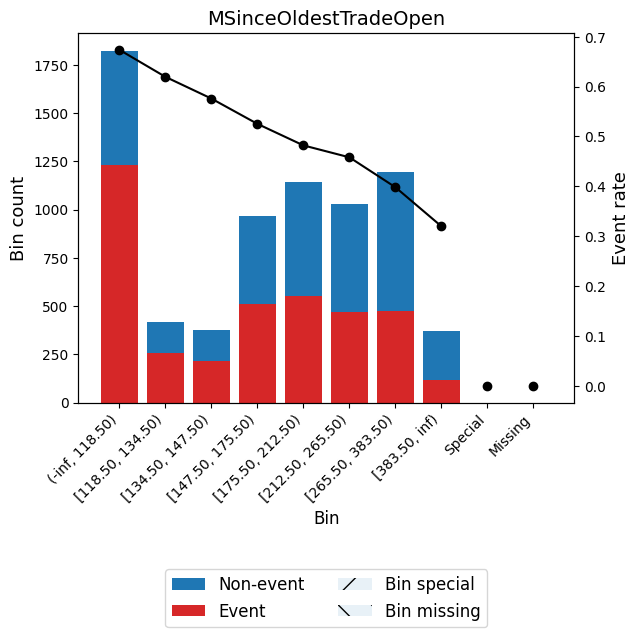

None


---

MSinceMostRecentTradeOpen 

                  Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 1.50)   1024   0.139872        433    591    0.577148   
1        [1.50, 5.50)   2711   0.370305       1256   1455    0.536702   
2        [5.50, 9.50)   1441   0.196831        674    767    0.532269   
3       [9.50, 19.50)   1405   0.191914        702    703    0.500356   
4        [19.50, inf)    740   0.101079        427    313    0.422973   
5             Special      0   0.000000          0      0    0.000000   
6             Missing      0   0.000000          0      0    0.000000   
Totals                  7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0      -0.218949  0.006645  0.000829  
1      -0.054945  0.001116  0.000140  
2      -0.037128  0.000271  0.000034  
3       0.090706  0.001581  0.000198  
4        0.40271  0.016324  0.002027  
5            0.0  0.000000  0.000000  
6            0.0  0.000000  0.000000  
To

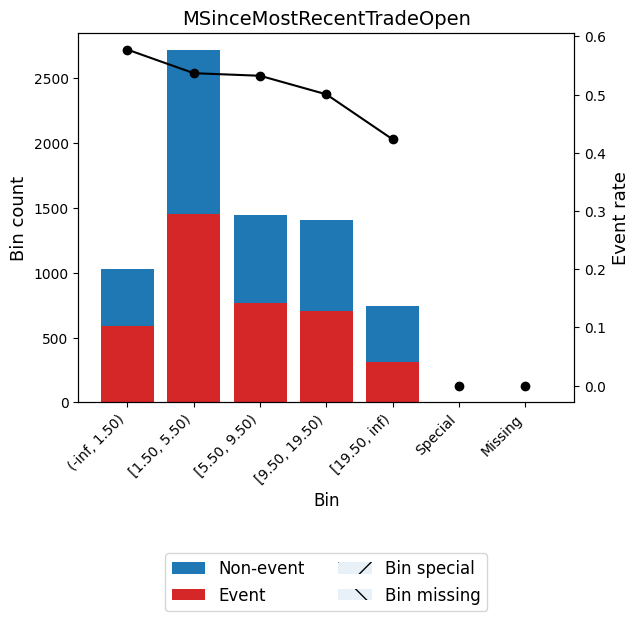

None


---

AverageMInFile 

                    Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 48.50)   1583   0.216227        465   1118    0.706254   
1        [48.50, 54.50)    376   0.051359        132    244    0.648936   
2        [54.50, 59.50)    374   0.051086        146    228    0.609626   
3        [59.50, 65.50)    540   0.073760        237    303    0.561111   
4        [65.50, 69.50)    380   0.051905        173    207    0.544737   
5        [69.50, 73.50)    381   0.052042        177    204    0.535433   
6        [73.50, 80.50)    684   0.093430        352    332    0.485380   
7        [80.50, 96.50)   1284   0.175386        737    547    0.426012   
8       [96.50, 116.50)    919   0.125529        555    364    0.396083   
9         [116.50, inf)    800   0.109275        518    282    0.352500   
10              Special      0   0.000000          0      0    0.000000   
11              Missing      0   0.000000          0      0    0.000000   
Totals  

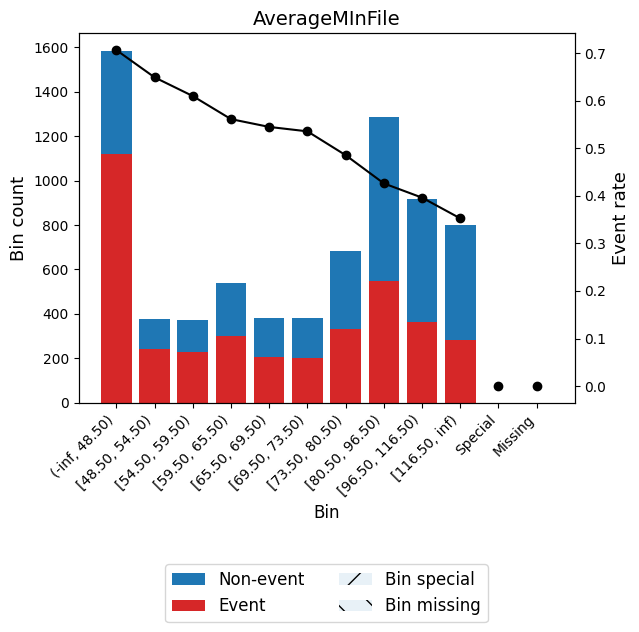

None


---

NumSatisfactoryTrades 

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 5.50)    783   0.106953        258    525    0.670498   
1         [5.50, 9.50)    631   0.086190        227    404    0.640254   
2        [9.50, 11.50)    376   0.051359        156    220    0.585106   
3       [11.50, 13.50)    480   0.065565        203    277    0.577083   
4       [13.50, 18.50)   1315   0.179620        638    677    0.514829   
5       [18.50, 22.50)    977   0.133452        496    481    0.492323   
6       [22.50, 24.50)    446   0.060921        227    219    0.491031   
7       [24.50, 31.50)   1188   0.162273        646    542    0.456229   
8         [31.50, inf)   1125   0.153668        641    484    0.430222   
9              Special      0   0.000000          0      0    0.000000   
10             Missing      0   0.000000          0      0    0.000000   
Totals                   7321   1.000000       3492   3829    0.523016   

             

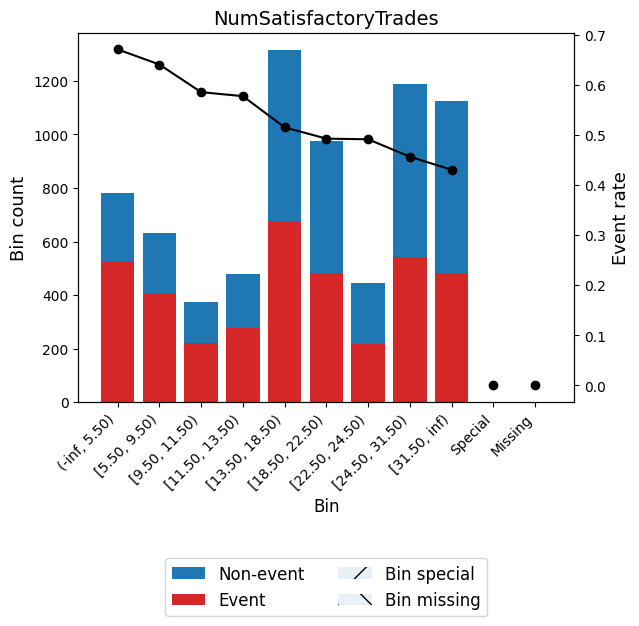

None


---

NumTrades60Ever2DerogPubRec 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.50)   5190   0.708920       2786   2404    0.463198   
1       [0.50, 1.50)   1245   0.170059        461    784    0.629719   
2       [1.50, 2.50)    492   0.067204        141    351    0.713415   
3        [2.50, inf)    394   0.053818        104    290    0.736041   
4            Special      0   0.000000          0      0    0.000000   
5            Missing      0   0.000000          0      0    0.000000   
Totals                 7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0       0.239602  0.040728  0.005079  
1      -0.438882  0.031923  0.003959  
2      -0.819897  0.042053  0.005114  
3      -0.933361  0.042893  0.005175  
4            0.0  0.000000  0.000000  
5            0.0  0.000000  0.000000  
Totals            0.157598  0.019327  
---------------------------------------------
OptimalBinning: Binary Binning Tabl

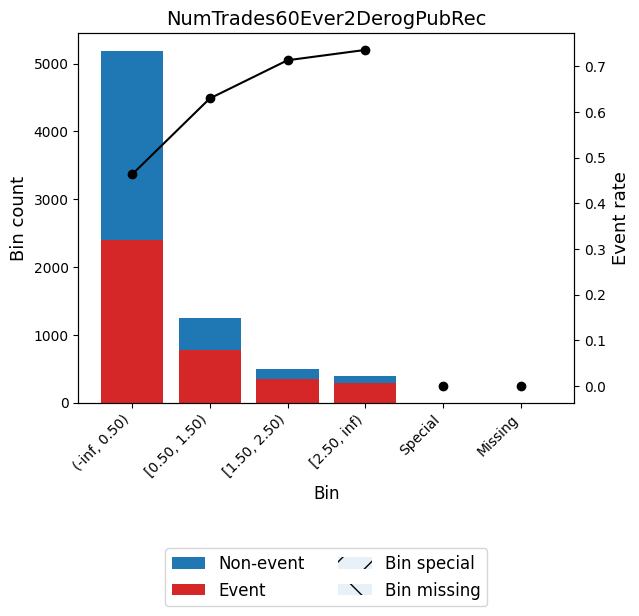

None


---

NumTrades90Ever2DerogPubRec 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.50)   5762   0.787051       2990   2772    0.481083   
1       [0.50, 1.50)   1002   0.136867        353    649    0.647705   
2        [1.50, inf)    557   0.076083        149    408    0.732496   
3            Special      0   0.000000          0      0    0.000000   
4            Missing      0   0.000000          0      0    0.000000   
Totals                 7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0       0.167833  0.022203  0.002772  
1      -0.516836  0.035356  0.004371  
2      -0.915192  0.058468  0.007064  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.116027  0.014207  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.135

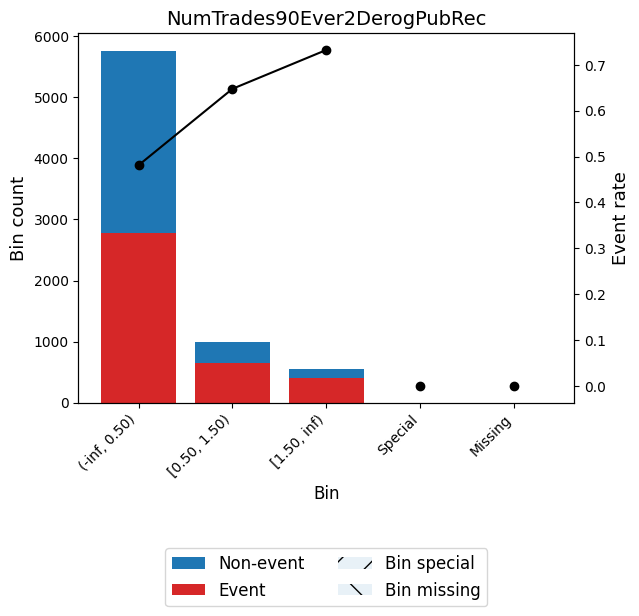

None


---

PercentTradesNeverDelq 

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 84.50)   1588   0.216910        445   1143    0.719773   
1       [84.50, 88.50)    452   0.061740        158    294    0.650442   
2       [88.50, 91.50)    429   0.058599        166    263    0.613054   
3       [91.50, 93.50)    414   0.056550        175    239    0.577295   
4       [93.50, 95.50)    525   0.071712        229    296    0.563810   
5       [95.50, 97.50)    562   0.076765        304    258    0.459075   
6         [97.50, inf)   3351   0.457724       2015   1336    0.398687   
7              Special      0   0.000000          0      0    0.000000   
8              Missing      0   0.000000          0      0    0.000000   
Totals                   7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0      -0.851208  0.145622  0.017672  
1      -0.528856  0.016678  0.002061  
2      -0.368037  0.007784  0.000968  
3   

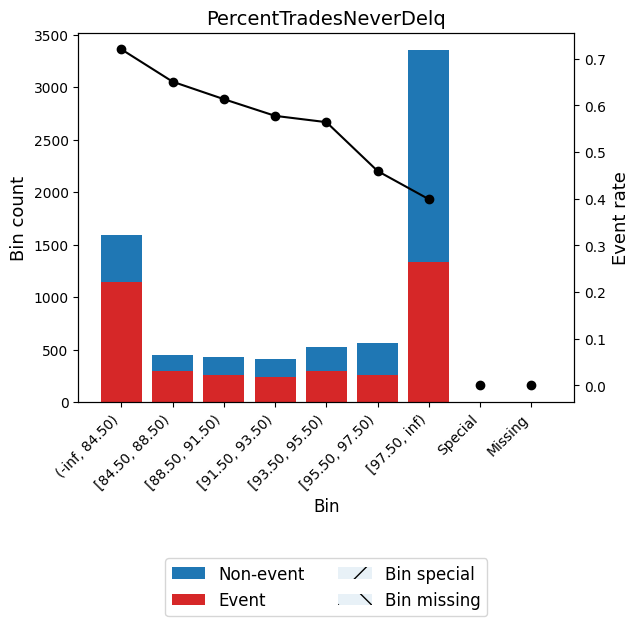

None


---

MSinceMostRecentDelq 

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, -7.50)    532   0.072668        229    303    0.569549   
1       [-7.50, 46.50)   6259   0.854938       2980   3279    0.523886   
2         [46.50, inf)    530   0.072394        283    247    0.466038   
3              Special      0   0.000000          0      0    0.000000   
4              Missing      0   0.000000          0      0    0.000000   
Totals                   7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0      -0.187882  0.002547  0.000318  
1      -0.003486  0.000010  0.000001  
2       0.228188  0.003773  0.000471  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.006330  0.000790  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index             

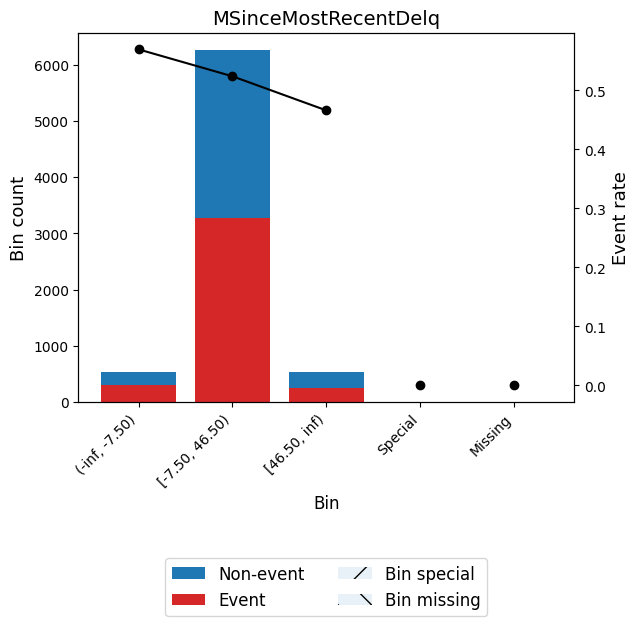

None


---

NumTradesOpeninLast12M 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.50)   2161   0.295178       1090   1071    0.495604   
1       [0.50, 1.50)   1742   0.237946        878    864    0.495982   
2       [1.50, 2.50)   1369   0.186996        640    729    0.532505   
3       [2.50, 3.50)    929   0.126895        422    507    0.545748   
4       [3.50, 4.50)    530   0.072394        233    297    0.560377   
5        [4.50, inf)    590   0.080590        229    361    0.611864   
6            Special      0   0.000000          0      0    0.000000   
7            Missing      0   0.000000          0      0    0.000000   
Totals                 7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0       0.109714  0.003559  0.000445  
1       0.108203  0.002790  0.000349  
2      -0.038077  0.000271  0.000034  
3      -0.091377  0.001057  0.000132  
4      -0.150565  0.001632  0.000204  
5      -0.363027  0.

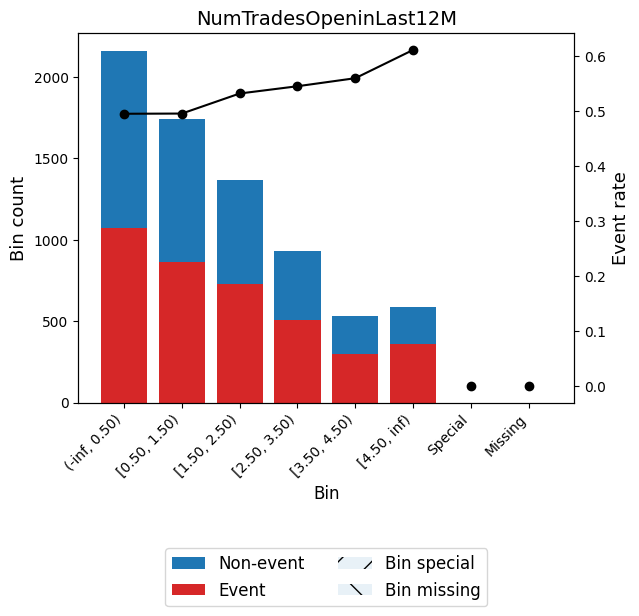

None


---

MSinceMostRecentInqexcl7days 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.50)   5262   0.718754       2213   3049    0.579437   
1       [0.50, 1.50)    415   0.056686        216    199    0.479518   
2       [1.50, 6.50)    901   0.123071        555    346    0.384018   
3        [6.50, inf)    743   0.101489        508    235    0.316285   
4            Special      0   0.000000          0      0    0.000000   
5            Missing      0   0.000000          0      0    0.000000   
Totals                 7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0      -0.228336  0.037118  0.004630  
1       0.174103  0.001721  0.000215  
2       0.564658  0.038720  0.004777  
3       0.863025  0.072582  0.008801  
4            0.0  0.000000  0.000000  
5            0.0  0.000000  0.000000  
Totals            0.150140  0.018422  
---------------------------------------------
OptimalBinning: Binary Binning Tab

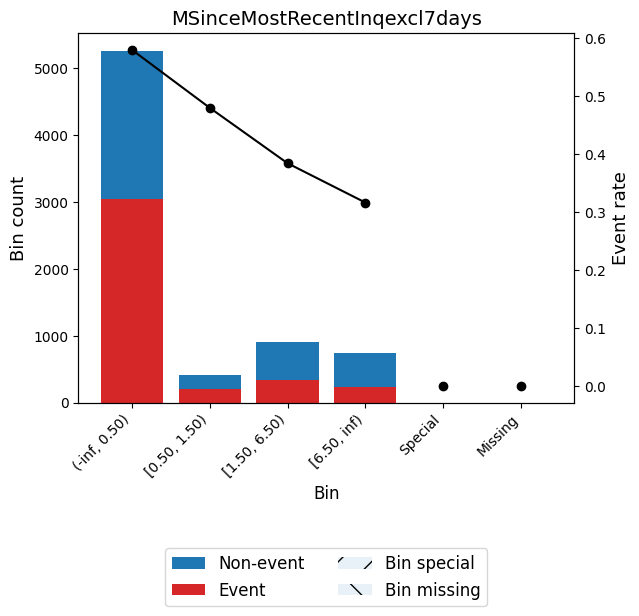

None


---

NumInqLast6M 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.50)   3184   0.434913       1716   1468    0.461055   
1       [0.50, 1.50)   1807   0.246824        874    933    0.516325   
2       [1.50, 3.50)   1536   0.209807        649    887    0.577474   
3        [3.50, inf)    794   0.108455        253    541    0.681360   
4            Special      0   0.000000          0      0    0.000000   
5            Missing      0   0.000000          0      0    0.000000   
Totals                 7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0       0.248224  0.026813  0.003343  
1       0.026804  0.000177  0.000022  
2      -0.220283  0.010089  0.001259  
3      -0.667901  0.045978  0.005643  
4            0.0  0.000000  0.000000  
5            0.0  0.000000  0.000000  
Totals            0.083057  0.010266  
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
----

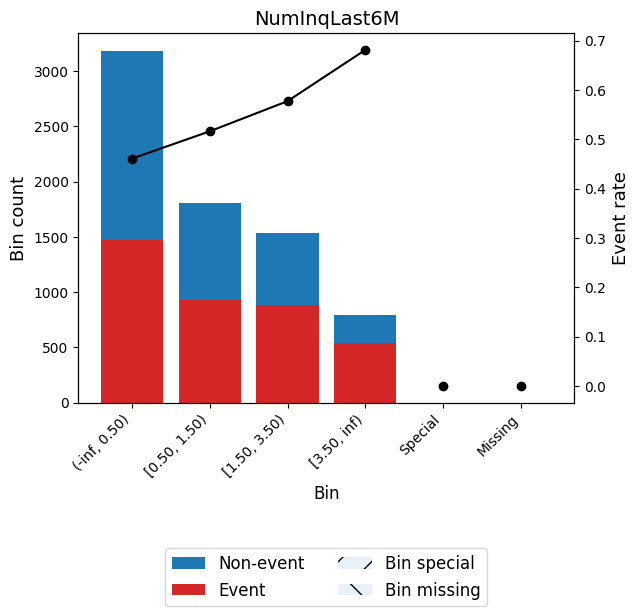

None


---

NumInqLast6Mexcl7days 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.50)   3297   0.450348       1767   1530    0.464058   
1       [0.50, 1.50)   1790   0.244502        857    933    0.521229   
2       [1.50, 2.50)    977   0.133452        420    557    0.570113   
3       [2.50, 3.50)    517   0.070619        211    306    0.591876   
4        [3.50, inf)    740   0.101079        237    503    0.679730   
5            Special      0   0.000000          0      0    0.000000   
6            Missing      0   0.000000          0      0    0.000000   
Totals                 7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0       0.236144  0.025133  0.003134  
1       0.007162  0.000013  0.000002  
2      -0.190181  0.004791  0.000598  
3      -0.279598  0.005450  0.000679  
4      -0.660401  0.041933  0.005148  
5            0.0  0.000000  0.000000  
6            0.0  0.000000  0.000000  
Totals         

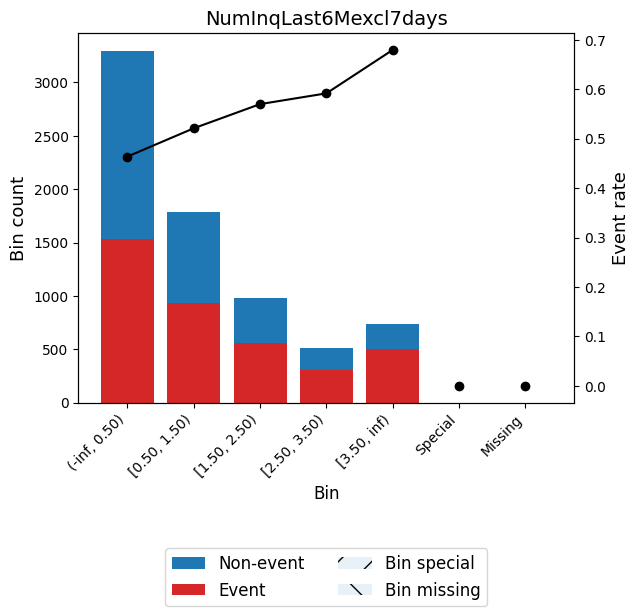

None


---

NetFractionRevolvingBurden 

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 12.50)   2601   0.355279       1623    978    0.376009   
1       [12.50, 17.50)    455   0.062150        283    172    0.378022   
2       [17.50, 22.50)    407   0.055593        228    179    0.439803   
3       [22.50, 28.50)    417   0.056959        219    198    0.474820   
4       [28.50, 37.50)    617   0.084278        286    331    0.536467   
5       [37.50, 47.50)    660   0.090152        265    395    0.598485   
6       [47.50, 59.50)    682   0.093157        244    438    0.642229   
7       [59.50, 78.50)    832   0.113646        232    600    0.721154   
8         [78.50, inf)    650   0.088786        112    538    0.827692   
9              Special      0   0.000000          0      0    0.000000   
10             Missing      0   0.000000          0      0    0.000000   
Totals                   7321   1.000000       3492   3829    0.523016   

        

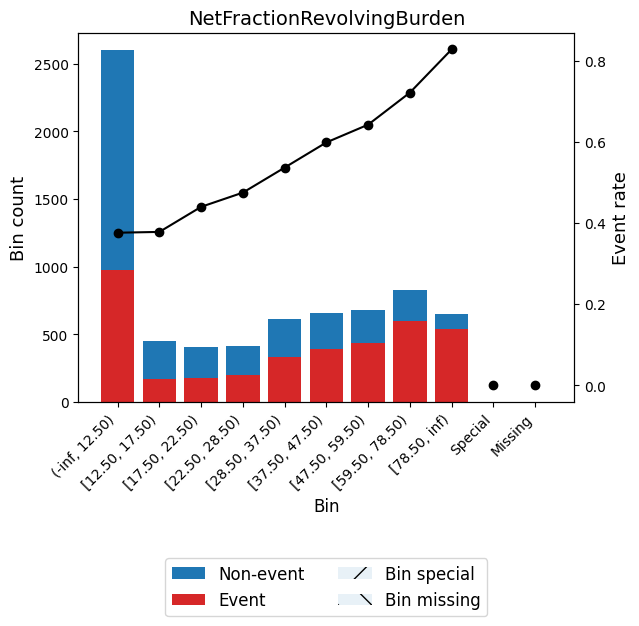

None


---

NetFractionInstallBurden 

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 35.50)   3291   0.449529       1719   1572    0.477666   
1       [35.50, 61.50)   1020   0.139325        506    514    0.503922   
2       [61.50, 74.50)    825   0.112690        365    460    0.557576   
3       [74.50, 84.50)    809   0.110504        349    460    0.568603   
4         [84.50, inf)   1376   0.187952        553    823    0.598110   
5              Special      0   0.000000          0      0    0.000000   
6              Missing      0   0.000000          0      0    0.000000   
Totals                   7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0       0.181523  0.014834  0.001852  
1       0.076442  0.000815  0.000102  
2        -0.1392  0.002173  0.000271  
3      -0.184026  0.003716  0.000464  
4      -0.305469  0.017282  0.002152  
5            0.0  0.000000  0.000000  
6            0.0  0.000000  0.000

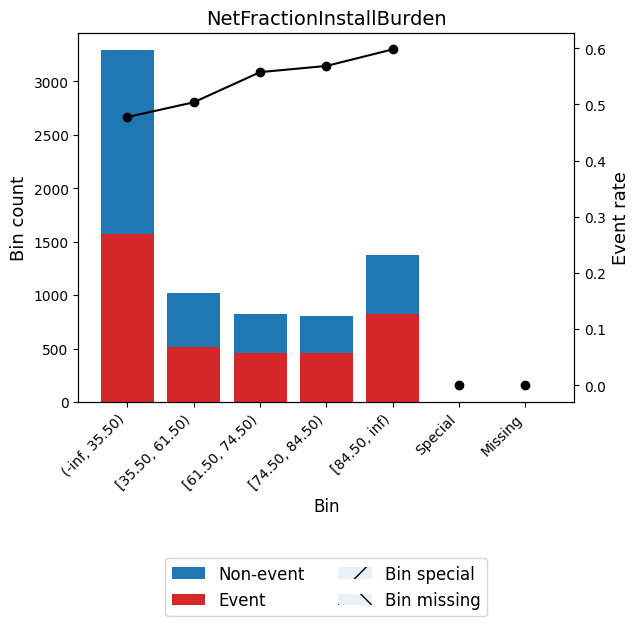

None


---

NumBank2NatlTradesWHighUtilization 

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.50)   3831   0.523289       2200   1631    0.425737   
1       [0.50, 1.50)   1759   0.240268        747   1012    0.575327   
2       [1.50, 2.50)    881   0.120339        312    569    0.645857   
3       [2.50, 3.50)    448   0.061194        133    315    0.703125   
4        [3.50, inf)    402   0.054911        100    302    0.751244   
5            Special      0   0.000000          0      0    0.000000   
6            Missing      0   0.000000          0      0    0.000000   
Totals                 7321   1.000000       3492   3829    0.523016   

             WoE        IV        JS  
0       0.391393  0.079864  0.009920  
1       -0.21149  0.010655  0.001329  
2      -0.508748  0.030146  0.003728  
3      -0.770094  0.034023  0.004151  
4      -1.013128  0.050894  0.006103  
5            0.0  0.000000  0.000000  
6            0.0  0.000000  0.000000  
To

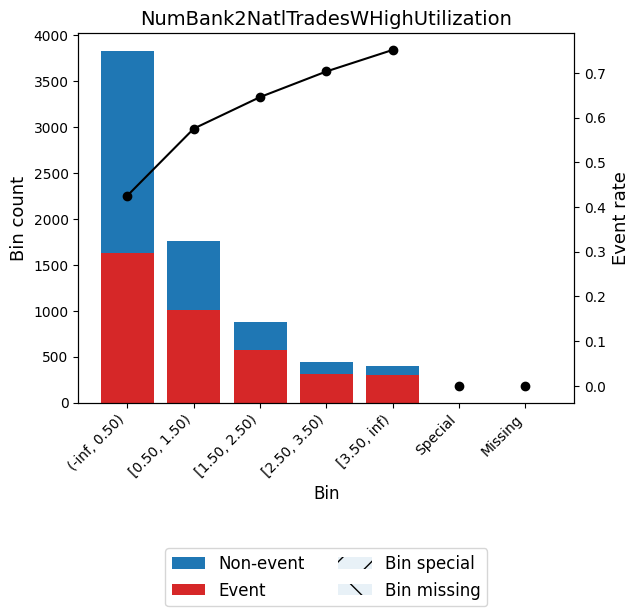

None


---

In [9]:
# features = df_copy.loc[:, df_copy.columns != 'RiskPerformance'].columns.to_list()
features = pd.DataFrame(binning_fit_params).T.reset_index()['index'].to_list()
for feature_name in features:
    print(feature_name, '\n')
    ob_univariate(X_train[feature_name],
                        y_train,
                        feature_name = feature_name,
                        monotonic_trend = binning_fit_params[feature_name]['monotonic_trend'],
                        plot=True)

    display(Markdown('---'))

In [10]:
ginis_dict = {'feature': [], 'gini': []}

for variable in features:
    optb = OptimalBinning(  
            name=variable,)
    
    binning_process = BinningProcess(
        variable_names=list(df[features].columns),
        binning_fit_params=binning_fit_params)
    
    binning_process.fit(df[features], df['RiskPerformance'])
      
    optb = binning_process.get_binned_variable(name=variable)
    binning_table = optb.binning_table.build()
    gini = round(optb.binning_table.gini, 4)
    #print(f"{variable} Gini: {gini}")
    
    ginis_dict['feature'].append(variable)
    ginis_dict['gini'].append(gini)

ginis_df = pd.DataFrame(ginis_dict)
ginis_df

,feature,gini
0,ExternalRiskEstimate,0.4964
1,MSinceOldestTradeOpen,0.2370
2,MSinceMostRecentTradeOpen,0.0653
3,AverageMInFile,0.2822
4,NumSatisfactoryTrades,0.1672
5,NumTrades60Ever2DerogPubRec,0.1830
6,NumTrades90Ever2DerogPubRec,0.1391
7,PercentTradesNeverDelq,0.2889
8,MSinceMostRecentDelq,0.0238
9,NumTradesOpeninLast12M,0.0659


### Feature Selection

In [11]:
selector = CorrelationFeatureSelector(features)
best_variables = selector.select_features(df, ginis_df)
best_variables

,feature,gini
0,ExternalRiskEstimate,0.4964
13,NetFractionRevolvingBurden,0.3508
3,AverageMInFile,0.2822
5,NumTrades60Ever2DerogPubRec,0.1830
10,MSinceMostRecentInqexcl7days,0.1755
4,NumSatisfactoryTrades,0.1672
11,NumInqLast6M,0.1466
14,NetFractionInstallBurden,0.0986


### WOE-Test

In [44]:
# Create an array of indices for your data
indices = np.arange(10459)

# Split the indices into train and test sets
train_val_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=62)

# Split the train indices into train and validation sets
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.3, random_state=62)

# Use the train, validation, and test indices as a mask for your data
train_mask = np.zeros((len(indices),), dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((len(indices),), dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((len(indices),), dtype=bool)
test_mask[test_idx] = True

In [45]:
woe_model_feats = best_variables.feature.values.tolist()
woe_lr_01 = create_woe_pipeline(df_copy[woe_model_feats][train_mask], 
                                df_copy[woe_model_feats][test_mask] ,
                                df_copy['RiskPerformance'][train_mask], 
                                df_copy['RiskPerformance'][test_mask])
print('model parameters:', woe_lr_01[1].intercept_, woe_lr_01[1].coef_) 

Gini : 0.5982913215407399
ROC-AUC : 0.79914566077037
F1 Score : 0.7533000880023466
model parameters: [0.09128705] [[-0.74347124 -0.3199691  -0.39324057 -0.04155318 -0.65088349 -0.88447808
  -0.40944986 -0.39174001]]


`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.


### Woe Explanation

In [46]:
# relative weights (Module 1)
st_weights = abs((np.std(woe_lr_01[0].transform(df_copy[woe_model_feats][train_mask]),0).to_numpy() * woe_lr_01[1].coef_))
sum_st_weights = np.sum(abs((np.std(woe_lr_01[0].transform(df_copy[woe_model_feats][train_mask]),0).to_numpy() * woe_lr_01[1].coef_)))
weight_vector = st_weights/sum_st_weights
weights = list(zip(df_copy[woe_model_feats][train_mask].columns, np.round(weight_vector, 3).ravel(), np.round(st_weights, 3).ravel()))
df_features = pd.DataFrame(weights, columns=['feature', 'weight', 'st_weights'])
print(df_features) # vectors of relative weights from logistic regression, ExternalRiskEstimate is the strongest feature

                        feature  weight  st_weights
0          ExternalRiskEstimate   0.375       0.746
1    NetFractionRevolvingBurden   0.115       0.228
2                AverageMInFile   0.110       0.218
3   NumTrades60Ever2DerogPubRec   0.009       0.017
4  MSinceMostRecentInqexcl7days   0.127       0.253
5         NumSatisfactoryTrades   0.162       0.321
6                  NumInqLast6M   0.074       0.147
7      NetFractionInstallBurden   0.029       0.057


Exact explainer: 10460it [00:37, 196.94it/s]                           


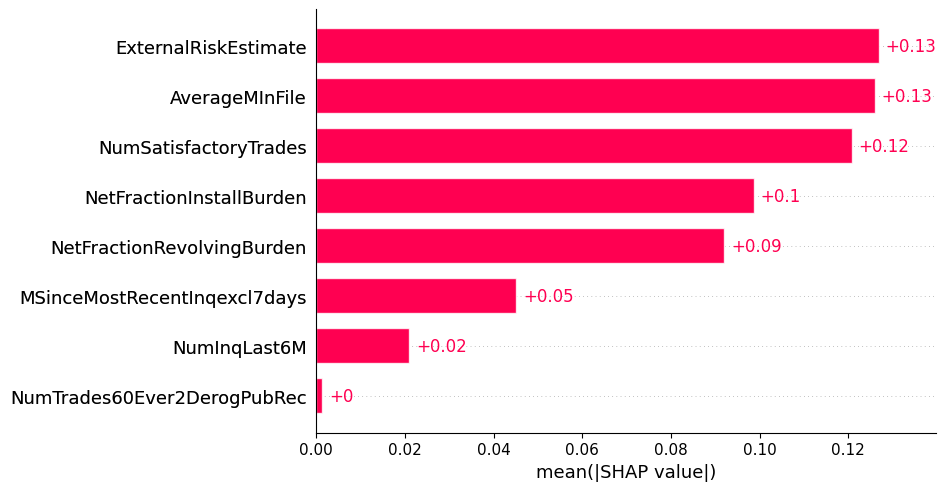

In [47]:
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

#load JS vis in the notebook
shap.initjs()

# feature_names = list(X.columns.values) 
feature_names = woe_lr_01[0].variable_names
X = df_copy[woe_lr_01[0].variable_names].copy()

# transform
observations = pd.DataFrame(woe_lr_01[0].transform(X).values, 
                            columns=feature_names)

# masker
masker = shap.maskers.Independent(observations.values, 100)

# explainer class
explainer = shap.Explainer(woe_lr_01[1].predict_proba, 
                           masker.data, 
                           feature_names=list(X.columns.values))

shap_values = explainer(X)
shap.plots.bar(shap_values[:, :, 1])

### Graph plot

In [ ]:
nodes = pd.read_csv('./data/FICO/heloc.csv')
node_features = nodes.to_numpy()

# Load the edges data into a Pandas dataframe
edges = pd.read_csv('./data/FICO/heloc_edges.txt', dtype=np.int32)

# Create a list of node IDs by using the indices of the nodes dataframe
node_ids = list(range(len(nodes)))

# Convert the edges dataframe into a list of node ID pairs
edge_pairs = [tuple(row) for row in edges.values]

In [ ]:
# Create a graph using the node IDs and edge pairs
G = nx.Graph()
G.add_nodes_from(node_ids)
G.add_edges_from(edge_pairs)

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

### GNN data loading

In [3]:
predict_attr = "RiskPerformance"
path_heloc = "./data/FICO/"
adj, features, labels, idx_train, idx_test = load_heloc('heloc', 
                                                        predict_attr, 
                                                        path=path_heloc
													    )

In [4]:
edge_index = convert.from_scipy_sparse_matrix(adj)[0]
edge_index = edge_index.to(device)
num_class = labels.unique().shape[0]-1
nfeat = features.shape[1]
features = features.to(device)
labels = labels.to(device)
num_epochs = 2500

### GNN Tuning

In [43]:
def objective(trial):
    # Define the hyperparameters to tune
    dropout = trial.suggest_float('dropout', 0.2, 0.6)
    nhid = trial.suggest_int('nhid', 10, 60)
    lr = trial.suggest_float('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2)

    # Create the model with the specified hyperparameters
    model = GIN(nfeat, nhid, num_class, dropout)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Train and evaluate the model
    auc_roc_test = train_and_evaluate(model, optimizer, features, edge_index, labels, idx_train, idx_test, device, num_epochs, model.__class__.__name__, tuning=True)
    
    # Return the Gini metric for optimization
    return ((auc_roc_test*2)-1)

initial_params = {
    "dropout": 0.5,
    "nhid": 16, 
    "lr": 1e-3,
    "weight_decay": 1e-5
}

study_name = f"GIN_fico"
storage = f"./models/saved_scores/study_{study_name}.pkl" 

try:
    # Load the existing study
    with open(storage, "rb") as f:
        study = pickle.load(f)
    print("Loaded previous study.")
except FileNotFoundError:

    # Create a new study if the file doesn't exist
    study = optuna.create_study(direction='maximize', study_name=study_name )
    study.enqueue_trial(initial_params)
    print("Created new study.")
    
study.optimize(objective, n_trials=10)
best_params = study.best_params
best_gini = study.best_value

with open(storage, "wb") as f:
    pickle.dump(study, f)
print("Study saved.")

print('Best Gini:', best_gini)
print('Best Hyperparameters:', best_params)

[I 2023-05-25 23:17:00,008] A new study created in memory with name: GIN_fico


Created new study.


Epochs: 100%|██████████| 2501/2501 [00:56<00:00, 44.44it/s, Train Loss=0.57, Val Loss=0.574] 
[I 2023-05-25 23:17:56,302] Trial 0 finished with value: 0.5524357564650781 and parameters: {'dropout': 0.5, 'nhid': 16, 'lr': 0.001, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.5524357564650781.
Epochs: 100%|██████████| 2501/2501 [01:14<00:00, 33.76it/s, Train Loss=0.367, Val Loss=0.775]
[I 2023-05-25 23:19:10,398] Trial 1 finished with value: 0.47649399307676643 and parameters: {'dropout': 0.30058023352475, 'nhid': 57, 'lr': 0.002158743851180484, 'weight_decay': 0.002056498049961467}. Best is trial 0 with value: 0.5524357564650781.
Epochs: 100%|██████████| 2501/2501 [01:10<00:00, 35.25it/s, Train Loss=0.438, Val Loss=0.655]
[I 2023-05-25 23:20:21,365] Trial 2 finished with value: 0.5243021787823254 and parameters: {'dropout': 0.21237044847342343, 'nhid': 47, 'lr': 0.008287245932056061, 'weight_decay': 0.0021540208962750242}. Best is trial 0 with value: 0.5524357564650781.
Epochs: 1

Study saved.
Best Gini: 0.5825143555284056
Best Hyperparameters: {'dropout': 0.5200761042765266, 'nhid': 31, 'lr': 0.0009949694642753684, 'weight_decay': 0.0011226799743118574}


### Ray-Tune

In [32]:
def tune_function(config):
    dropout = config["dropout"]
    nhid = config["nhid"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]

    # Create the model and optimizer with the specified hyperparameters
    model = GCN(nfeat, nhid, num_class, dropout)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Train and evaluate the model
    auc_roc_test = train_and_evaluate(model, optimizer, features, edge_index, labels, idx_train, idx_test, device, num_epochs)
    
    # Return the AUC-ROC metric for optimization
    return ((auc_roc_test * 2) - 1)

In [33]:
from optuna.samplers import TPESampler
sampler = TPESampler(seed=10)

study_name = "GCNN_fico"
storage = f"study_{study_name}.pkl"

def load_or_create_study(storage, study_name):
    try:
        # Load the existing study
        with open(storage, "rb") as f:
            study = pickle.load(f)
        print("Loaded previous study.")
    except FileNotFoundError:
        # Create a new study if the file doesn't exist
        study = optuna.create_study(direction='maximize', study_name=study_name)
        print("Created new study.")
    
    return study

# Load or create the study
study = load_or_create_study(storage, study_name)

search_space = {
    "dropout": tune.uniform(0.2, 0.6),
    "nhid": tune.randint(15, 35),
    "lr": tune.loguniform(1e-4, 1e-2),
    "weight_decay": tune.loguniform(1e-6, 1e-2)
}

# Run the optimization
analysis = tune.run(
    tune_function,
    config=search_space,
    num_samples=2,
    search_alg=optuna.create_study(direction='maximize', study_name=study_name, sampler=sampler),
    metric="auc_roc_test",
    mode="max"
)

# Retrieve the best hyperparameters and save the study
best_trial = analysis.get_best_trial("auc_roc_test", mode="max")
best_params = best_trial.config
best_gini = best_trial.last_result["auc_roc_test"]

with open(storage, "wb") as f:
    pickle.dump(study, f)
print("Study saved.")

print('Best Gini:', best_gini)
print('Best Hyperparameters:', best_params)


[I 2023-05-21 16:57:36,800] A new study created in memory with name: GCNN_fico


Loaded previous study.


2023-05-21 16:57:38,021	ERROR services.py:1197 -- Failed to start the dashboard , return code 1
2023-05-21 16:57:38,022	ERROR services.py:1222 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2023-05-21 16:57:38,023	ERROR services.py:1232 -- Couldn't read dashboard.log file. Error: [Errno 2] No such file or directory: '/tmp/ray/session_2023-05-21_16-57-36_836424_49216/logs/dashboard.log'. It means the dashboard is broken even before it initializes the logger (mostly dependency issues). Reading the dashboard.err file which contains stdout/stderr.
2023-05-21 16:57:38,029	ERROR services.py:1266 -- 
The last 20 lines of /tmp/ray/session_2023-05-21_16-57-36_836424_49216/logs/dashboard.err (it contains the error message from the dashboard): 
  File "/Users/alessandrofogli/miniconda3/envs/thesis/lib/python

: 

: 

### Retrieve model

In [12]:
def retrieve_model(architecture):

    study_name = F"{architecture}_fico"
    storage = f"./models/saved_scores/study_{study_name}.pkl" 

    with open(storage, "rb") as f:
        study = pickle.load(f)
    
    params = study.best_params
    best_gini = study.best_value

    return params

In [13]:
best_params = retrieve_model('GIN')

### Load and Evaluate - Loss

Epochs: 100%|██████████| 2501/2501 [01:05<00:00, 37.96it/s, Train Loss=0.516, Val Loss=0.554]


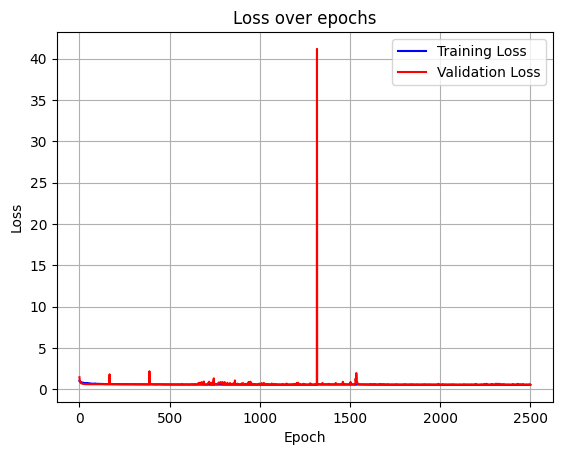

AUC-ROC: 0.7958391366320504
Gini: 0.5916782732641008
F1-Score: 0.7497779093870299


In [11]:
model = GIN(nfeat=nfeat, nhid=best_params['nhid'], nclass=num_class, dropout=best_params['dropout'])
#model_name = f'{model.__class__.__name__}'
#model.load_state_dict(torch.load(f'./weights/GIN_weights.pt'))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_auc, gnn_probs, f1_sc = train_and_evaluate(
                                                 model, optimizer, features, 
                                                 edge_index, labels, idx_train, 
                                                 idx_test, device, num_epochs, 
                                                 model.__class__.__name__, 
                                                 plot_loss=True, save_plot=True
                                                 )
print(f'AUC-ROC: {best_auc}')
print(f'Gini: {best_auc*2-1}')
print(f'F1-Score: {f1_sc}')

### Integration model

In [30]:
eps_=1.6e-10

def logit(p):
    p = p + eps_
    return np.log((p + eps_)/((1-p) + eps_))


In [31]:
woe_model_feats = best_variables.feature.values.tolist()
woe_lr_01 = create_woe_pipeline(df_copy.loc[idx_train.numpy(), woe_model_feats], 
                                df_copy.loc[idx_test.numpy(), woe_model_feats] ,
                                df_copy.loc[idx_train.numpy(), 'RiskPerformance'], 
                                df_copy.loc[idx_test.numpy(), 'RiskPerformance']
                                )


print('model parameters:', woe_lr_01[1].intercept_, woe_lr_01[1].coef_) 

Gini : 0.5857039299531663
ROC-AUC : 0.7928519649765832
F1 Score : 0.7442680776014109
model parameters: [0.10849341] [[-0.73068517 -0.33752866 -0.42029465 -0.10784469 -0.70166747 -0.84436628
  -0.24286253 -0.40462152]]


`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.


In [32]:
combined_scores_train = pd.DataFrame()
combined_scores_test = pd.DataFrame()

combined_scores_train['gnn_score'] = logit(gnn_probs[idx_train][:,1])
combined_scores_train['woe_score'] = logit(woe_lr_01.predict_proba(df_copy.loc[idx_train.numpy(),
                                                                    woe_model_feats])[:,1])
combined_scores_train['is_default'] = labels[idx_train].cpu().detach().numpy()


combined_scores_test['gnn_score'] = logit(gnn_probs[idx_test][:,1])
combined_scores_test['woe_score'] = logit(woe_lr_01.predict_proba(df_copy.loc[idx_test.numpy(),
                                                                              woe_model_feats])[:,1])
combined_scores_test['is_default'] = labels[idx_test].cpu().detach().numpy()


In [33]:

integration_feats = ['gnn_score', 'woe_score']

def objective(trial):
    logreg_penalty = trial.suggest_categorical("logreg_penalty", ('l1', 'l2'))
    logreg_intercept_scaling = trial.suggest_float('logreg_intercept_scaling', 1e-3, 1, log=True)
    logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)

    classifier_obj = LogisticRegression(fit_intercept=True, solver='liblinear', C=logreg_c,
                                        penalty=logreg_penalty, random_state=72)
    
    classifier_obj.fit(combined_scores_train[integration_feats], combined_scores_train.is_default.to_numpy().ravel())
    
    # Store the classifier object in the user_attrs dictionary of the trial
    trial.set_user_attr('best_classifier', classifier_obj)

    # Scoring method:
    y_pred_proba = classifier_obj.predict_proba(combined_scores_test[integration_feats])
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)  # Apply threshold and convert to binary labels
    
    auc = roc_auc_score(labels[idx_test].cpu().detach().numpy(), y_pred_proba[:, 1])
    gini = auc * 2 - 1
    f1 = f1_score(labels[idx_test].cpu().numpy(), y_pred)
    
    return gini

# Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Get the best trial's information
best_trial = study.best_trial
best_gini = best_trial.value

# Print the Gini, AUC, and F1 score for the best trial
best_classifier = best_trial.user_attrs['best_classifier']
best_y_pred_proba = best_classifier.predict_proba(combined_scores_test[integration_feats])
best_y_pred = (best_y_pred_proba[:, 1] >= 0.5).astype(int)
best_auc = roc_auc_score(labels[idx_test].cpu().detach().numpy(), best_y_pred_proba[:, 1])
best_f1 = f1_score(labels[idx_test].cpu().numpy(), best_y_pred)

print(f"Best Gini: {best_gini}")
print(f"Best AUC: {best_auc}")
print(f"Best F1 Score: {best_f1}")


[I 2023-05-25 23:56:38,569] A new study created in memory with name: no-name-816411c2-1f5e-4e34-a9a2-f06bff992bfb
[I 2023-05-25 23:56:38,580] Trial 0 finished with value: 0.603764610059051 and parameters: {'logreg_penalty': 'l1', 'logreg_intercept_scaling': 0.08035204796556922, 'logreg_c': 0.04815235777381915}. Best is trial 0 with value: 0.603764610059051.
[I 2023-05-25 23:56:38,588] Trial 1 finished with value: 0.6201124007330483 and parameters: {'logreg_penalty': 'l2', 'logreg_intercept_scaling': 0.9502340696069171, 'logreg_c': 3.5226421992096185e-05}. Best is trial 1 with value: 0.6201124007330483.
[I 2023-05-25 23:56:38,596] Trial 2 finished with value: 0.619877010792099 and parameters: {'logreg_penalty': 'l2', 'logreg_intercept_scaling': 0.02570116319839016, 'logreg_c': 0.00018929629549828988}. Best is trial 1 with value: 0.6201124007330483.
[I 2023-05-25 23:56:38,603] Trial 3 finished with value: 0.6201058847485239 and parameters: {'logreg_penalty': 'l2', 'logreg_intercept_scali

Best Gini: 0.6201726735899
Best AUC: 0.81008633679495
Best F1 Score: 0.7590325470289639


In [34]:
# Getting the best score:
print(f"The best value is : \n{study.best_value:.2%}")
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")

The best value is : 
62.02%
The best parameters are : 
{'logreg_penalty': 'l2', 'logreg_intercept_scaling': 0.9982889749203134, 'logreg_c': 1.9417910181478903e-05}


In [35]:
#Get the best classifier object
best_classifier = study.best_trial.user_attrs['best_classifier']
#Get the predicted probabilities for label 1
y_pred_prob = best_classifier.predict_proba(combined_scores_test[integration_feats])[:, 1]

In [36]:
print(best_classifier.intercept_, best_classifier.coef_)

[0.0024994] [[0.0586125  0.04057588]]


### Result plot 📊

In [37]:
output_labels_array = labels[idx_test].cpu().detach().numpy() 

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


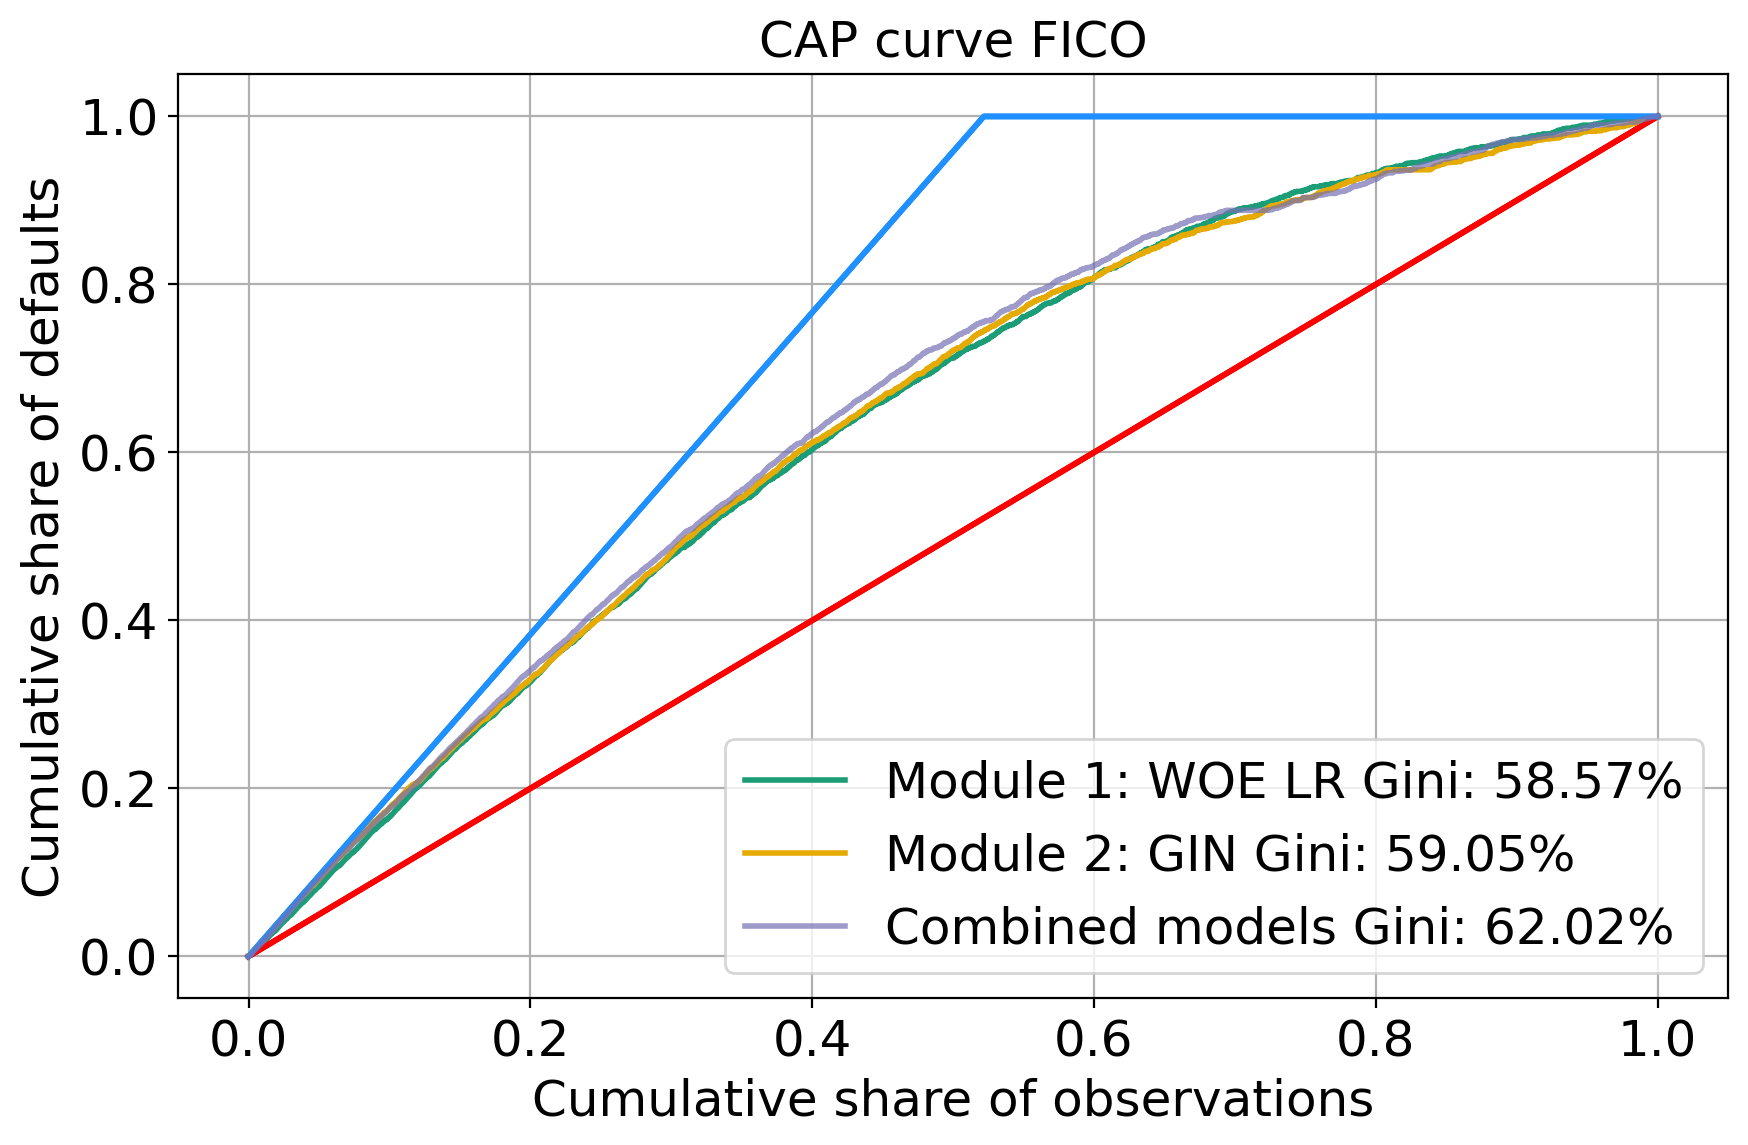

In [42]:
# Discriminatory power
fig = plt.figure(figsize=(10, 6), dpi=200)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
line_color = colors(2)
line_color = np.array(line_color)
line_color[3] = 0.7  # Adjust the transparency (alpha value) between 0 and 1
line_color = tuple(line_color)
plot_cap(df_copy.loc[idx_test.numpy(), 'RiskPerformance'], woe_lr_01.predict_proba(df_copy.loc[idx_test.numpy(), woe_model_feats])[:,1], \
         model_name='Module 1: WOE LR', line_color=colors(0))
plot_cap(output_labels_array, gnn_probs[idx_test][:,1] , \
         model_name='Module 2: GIN', line_color=colors(5))
plot_cap(output_labels_array, y_pred_prob , \
         model_name='Combined models', line_color=line_color)

plt.grid()
plt.tick_params(labelsize=18)

plt.xlabel('Cumulative share of observations', fontsize=18)
plt.ylabel('Cumulative share of defaults', fontsize=18)

plt.title('CAP curve FICO', fontsize=18)
plt.legend(fontsize=18) 
#plt.tight_layout()
#plt.savefig('graphics/discrimination_diagram.png', bbox_inches='tight')
plt.show()

### GNN explanation WIP 🚦

In [101]:
df.columns[:-1]

Index(['RiskPerformance', 'ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization'],
      dtype='object')

In [ ]:
#feature_names = df_copy.loc[:, df_copy.columns != 'RiskPerformance'].columns
weights_sum = {}

# Initialize the weights_sum dictionary with feature names as keys and initial sum of weights as 0
for feature_name in feature_names:
    weights_sum[feature_name] = 0

# Iterate over the layers of the model
for layer in model.modules():
    if isinstance(layer, nn.Linear):
        # Retrieve the weight tensor for the current layer
        weights = layer.weight

        # Iterate over the features in the weight tensor
        for feature_idx in range(weights.shape[1]):
            # Extract the weights for the current feature
            feature_weights = weights[:, feature_idx]

            # Add the sum of weights for the current feature
            feature_name = feature_names[feature_idx]
            weights_sum[feature_name] += feature_weights.sum().item()

# Create a DataFrame from the dictionary of feature weights
df_feature_weights = pd.DataFrame(weights_sum.items(), columns=['Feature', 'Weight'])
df_feature_weights['Weight_pos'] = np.where(df_feature_weights['Weight'] > 0, df_feature_weights['Weight'], 0)
df_feature_weights['Points'] = ((df_feature_weights.Weight_pos / df_feature_weights.Weight_pos.sum())*100).astype(int)
df_feature_weights

In [70]:
feature_names = df_copy[df_copy != 'RiskPerformance'].columns.tolist()

weights_sum = {}

# Initialize the weights_sum dictionary with feature names as keys and initial sum of weights as 0
for feature_name in feature_names:
    weights_sum[feature_name] = 0

# Iterate over the layers of the model
for layer in model.modules():
    if isinstance(layer, nn.Linear):
        # Retrieve the weight tensor for the current layer
        weights = layer.weight

        # Iterate over the features in the weight tensor
        for feature_idx in range(weights.shape[1]):
            # Extract the weights for the current feature
            feature_weights = weights[:, feature_idx]

            # Add the sum of weights for the current feature
            feature_name = feature_names[feature_idx]
            weights_sum[feature_name] += feature_weights.sum().item()

# Calculate the standardized weights
st_weights = abs(np.array(list(weights_sum.values())) / np.sum(np.abs(list(weights_sum.values()))))

# Create a DataFrame from the dictionary of feature weights
df_feature_weights = pd.DataFrame(weights_sum.items(), columns=['Feature', 'Weight'])

# Add a new column for the standardized weights
df_feature_weights['st_weights'] = st_weights

print(df_feature_weights)



IndexError: list index out of range

In [64]:
for layer in model.modules():
    if isinstance(layer, nn.Linear):
        # Retrieve the weight tensor for the current layer
        weights = layer.weight

        # Get the number of features in the weight tensor
        num_features = weights.shape[1]

        print(f"Number of features in weight tensor: {num_features}")


Number of features in weight tensor: 23
Number of features in weight tensor: 31
Number of features in weight tensor: 31


In [ ]:
# Import the Data class and torch.sparse
from torch_geometric.data import Data
from torch import sparse

# Create a list to store the Data objects
data_list = []

# Iterate over the graphs in your dataset
for graph_idx in range(len(features)):
    # Get the node features and the adjacency matrix for a graph
    node_features = features[graph_idx]
    adj = adj[graph_idx]

    # Convert the PyTorch tensor to a scipy sparse matrix
    adj = sp.coo_matrix(adj)

    # Convert the sparse matrix to a PyTorch sparse tensor
    indices = torch.from_numpy(np.vstack((adj.row, adj.col)).astype(np.int64))
    values = torch.from_numpy(adj.data.astype(np.float32))
    size = torch.Size(adj.shape)
    adj = torch.sparse.FloatTensor(indices, values, size)

    # Get the label for the graph
    label = labels[graph_idx]

    # Create a Data object for the graph
    data = Data(x=node_features, edge_index=adj._indices(), edge_attr=adj._values(), y=label)

    # Append the Data object to the list
    data_list.append(data)


In [65]:
len(df.columns)

24

In [ ]:
# Import the library
from captum.attr import SensitivityN

# Create an instance of the SensitivityN class
sensitivity = SensitivityN(model)

# Define a function to get the output probability for a given class index
def get_output_prob(input, target):
    output = model(input)
    prob = torch.nn.functional.softmax(output, dim=1)
    return prob[:, target]

# Choose a class index to analyze (e.g. 0)
target = 0

# Choose an input sample to analyze (e.g. the first one in the dataset)
input = data.x[0]

# Compute the feature attributions using sensitivity analysis
attributions = sensitivity.attribute(input, target=target, n_samples=10)

# Print the attributions
print(attributions)


In [20]:
df_weights = pd.read_csv('data/gnn_weights.csv')

In [25]:
%config InlineBackend.figure_format = 'retina'

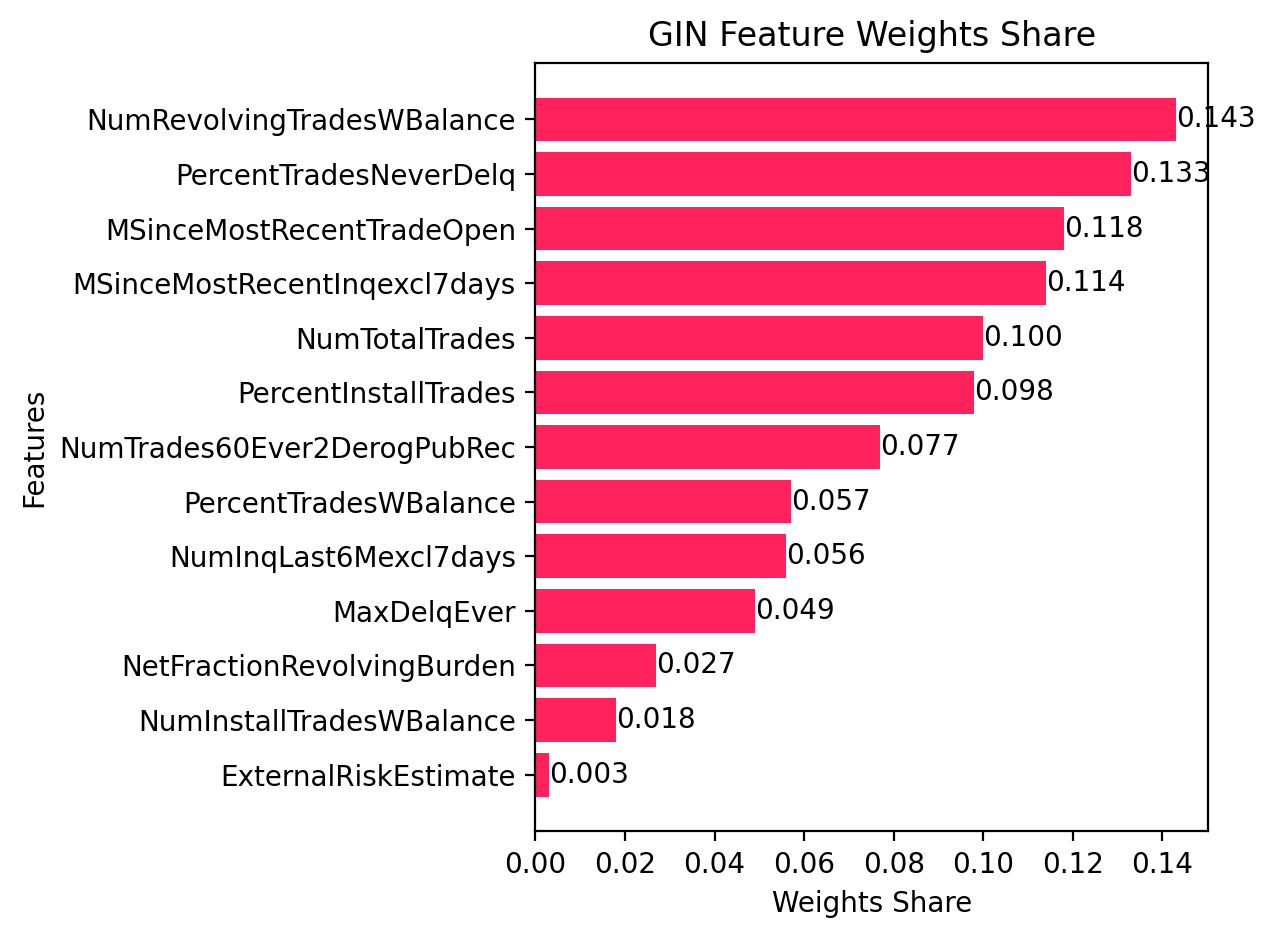

In [67]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Example DataFrame
data = {'features': ['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen',
                     'AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec',
                     'NumTrades90Ever2DerogPubRec', 'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
                     'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
                     'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days',
                     'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden',
                     'NetFractionInstallBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
                     'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
        'weights_share': [0.003, 0.0, 0.118, 0.0, 0.0, 0.077, 0.0, 0.133, 0.0, 0.0, 0.049, 0.100,
                    0.0, 0.098, 0.114, 0.0, 0.056, 0.027, 0.0, 0.143, 0.018, 0.0, 0.057]}
df = pd.DataFrame(data)

positive_df = df[df['weights_share'] > 0]
sorted_df = positive_df.sort_values('weights_share', ascending=True)
#color_scale = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [(1, 0, 0), (0.31796406, 0, 0)])
custom_color = mcolors.to_rgb('#FF225D')


plt.figure( dpi=100, figsize=(6.4, 4.8))
# Plotting the bar chart
plt.barh(sorted_df['features'], sorted_df['weights_share'], color=custom_color) #
plt.xlabel('Weights Share')
plt.ylabel('Features')
plt.title('GIN Feature Weights Share')


for i, value in enumerate(sorted_df['weights_share']):
    plt.text(value, i, f'{value:.3f}', ha='left', va='center')

# Adjusting the layout
plt.tight_layout()
plt.savefig('gnn_feature_weights.png')
# Display the plot
plt.show()

In [131]:
# # Define a dictionary to store the feature weights
# feature_weights = {}

# # Iterate over the model's state dictionary
# for key, value in model.state_dict().items():
#     if 'weight' in key:
#         layer_weights = value  # Get the weights for the layer
#         feature_sum = layer_weights.sum(dim=0)  # Sum the weights for each feature
#         feature_weights[key] = feature_sum  # Store the feature sum in the dictionary

# # Print the feature weights for each layer
# for key, value in feature_weights.items():
#     print(f"Layer: {key}")
#     for feature_idx, weight_sum in enumerate(value):
#         print(f"Feature {feature_idx + 1}: {weight_sum}")
#     print()

In [ ]:
# feature_weights = {}

# # Iterate over the model's state dictionary
# for key, value in model.state_dict().items():
#     if 'weight' in key:
#         layer_weights = value  # Get the weights for the layer
#         feature_sum = layer_weights.sum()  # Sum the weights
#         feature_weights[key] = feature_sum  # Store the feature sum in the dictionary

# # Print the feature weights for each layer
# for key, value in feature_weights.items():
#     print(f"Layer: {key}")
#     print(f"Total Weight: {value.item()}")
#     print()

In [ ]:
# # Initialize an empty list to store the weights for each feature
# all_weights = [[] for _ in range(24)]

# # Iterate over the layers of the model
# for layer in model.modules():
#     if isinstance(layer, nn.Linear):
#         # Retrieve the weight tensor for the current layer
#         weights = layer.weight

#         # Iterate over the features in the weight tensor
#         for feature_idx in range(weights.shape[1]):
#             # Extract the weights for the current feature and append to the corresponding list
#             feature_weights = weights[:, feature_idx].tolist()
#             all_weights[feature_idx].extend(feature_weights)

# # Print the concatenated weights for each feature
# for feature_idx, weights in enumerate(all_weights):
#     print(f"Weights for feature {feature_idx + 1}:")
#     print(weights)
#     print()


### GNN Shap WIP 🚦

In [89]:
model = GIN(nfeat=nfeat, nhid=best_params['nhid'], nclass=num_class, dropout=best_params['dropout'])
model.to(device)

GIN(
  (mlp1): Sequential(
    (0): Linear(in_features=23, out_features=31, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=31, out_features=31, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=23, out_features=31, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=31, out_features=31, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ))
  (fc): Linear(in_features=31, out_features=1, bias=True)
  (dropout): Dropout(p=0.5200761042765266, inplace=False)
)

In [91]:
explainer = shap.Explainer(model, features[idx_train])
explainer

In [ ]:
import warnings

test_instance = features[idx_test[0]]

# Reshape test instance to have a shape of (1, num_features)
test_instance_np = test_instance_np.reshape(1, -1)

# Convert the reshaped test instance to a tensor
test_instance_tensor = torch.from_numpy(test_instance_np).to(device)

# Create the explainer
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    explainer = shap.Explainer(model, features[idx_train].cpu().numpy())

# Calculate SHAP values
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer(test_instance_tensor, edge_index)  # Pass the edge_index argument


### Architecture visualization WIP 🚦

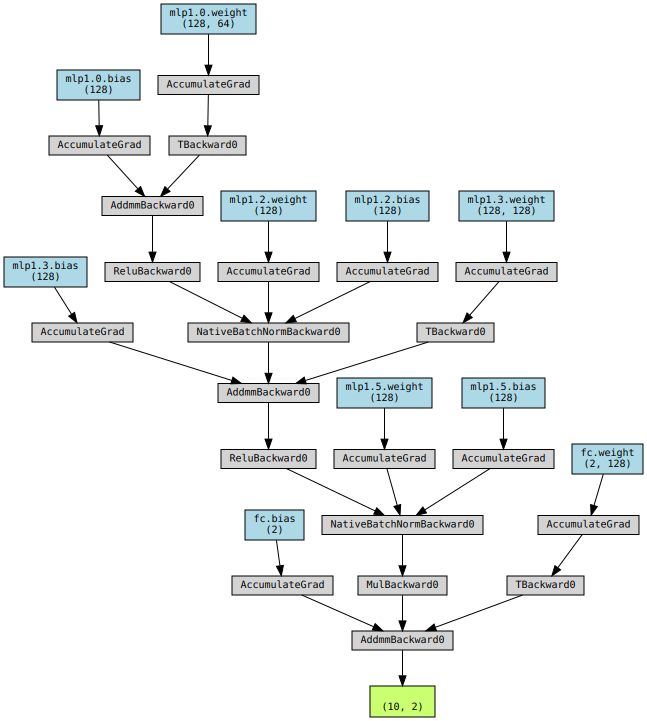

In [18]:
# Create a dummy input and edge index
x = torch.randn(10, 64)
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]])

# Create a GIN model instance
model = GIN(nfeat=64, nhid=128, nclass=2, dropout=0.5)

# Pass the input tensor and edge index through the model to get the output tensor
y = model(x, edge_index)

# Use torchviz to create a visualization of the model graph
dot = make_dot(y, params=dict(model.named_parameters()))

# Display the plot in the notebook
dot.format = 'png'
dot.render(filename='GIN_model_architecture', format='png', cleanup=True)
dot